In [1]:
import ROOT as r
import coffea
import coffea.hist as hist
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak
import mplhep

from sklearn.cluster import DBSCAN
import numba

Welcome to JupyROOT 6.18/00


In [2]:
import awkward as ak
from coffea import hist, processor


# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "cluster": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("eta", "eta", 50, -3, 3),                
                hist.Bin("phi", "phi", 50, -np.pi, np.pi),
                hist.Bin("size", "Cluster size", 50, 0, 100),                
            ),
            "nCluster": hist.Hist(
                "Events",
                hist.Cat("algo", "algo"),
                hist.Bin("nClusters", "nCluster", 10, 0, 10),                
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    @numba.njit
    def CAcluster(self,X,dR=1.0,nCore=50):
        vectors=ak.zip({
            'pt':ak.ones_like(X.phi),
            'eta':X.eta,
            'phi':X.phi,
            'mass':ak.zeros_like(X.phi)
        })
        cls_eta=[]
        cls_phi=[]
        cls_size=[]
        ncls   =[]
        for v in vectors:
            v = ak.to_numpy(v)
            v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                         dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
            clusterVals = cluster(v,R=dR,algo="cambridge")
            #include all rechits with ptmin=0
            _jets = clusterVals.inclusive_jets(ptmin=0)
            cls_eta.append([j.eta for j in _jets if len(j)>=nCore])
            cls_phi.append([j.phi for j in _jets if len(j)>=nCore])
            cls_size.append([len(j) for j in _jets if len(j)>=nCore])            
            ncls.append(len([j.eta for j in _jets if len(j)>=nCore]))
        return np.array(ncls),ak.Array(cls_eta),ak.Array(cls_phi),ak.Array(cls_size)
    
    @numba.njit
    def DBScan(self,X,nCore,eps):
        points=ak.zip([X.eta,X.phi])
        
        nCS=[]
        masks=[]
        etas=[]
        phis=[]
        size=[]
        for x in points:
            x=np.stack(ak.unzip(x),axis=1)## format into DBSCAN x=[ [x1,y1],[x2,y2] ... ]
            db = DBSCAN(eps=eps, min_samples=nCore).fit(x)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_    
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #         print(labels,set(labels),n_clusters_)
            cl_eta=[]
            cl_phi=[]
            cl_size=[]
            for iCs in range(n_clusters_):
                rh_eta=x[labels==iCs][:,0]
                rh_phi=x[labels==iCs][:,1]            
                cl_eta.append(np.mean(rh_eta))
                cl_phi.append(np.mean(rh_phi))            
                cl_size.append(len(rh_eta))
            nCS.append(n_clusters_)
            masks.append(core_samples_mask)
            etas.append(cl_eta)
            phis.append(cl_phi)
            size.append(cl_size)
        return np.array(nCS),ak.Array(etas),ak.Array(phis),ak.Array(size)    

    def performClusters(self,algo,X):
        if "CA" in algo['name']:
            nCS,eta,phi,size = self.CAcluster(X,dR=algo['pams']['dR'],nCore=algo['pams']['nCore'])
        elif "DB" in algo['name']:
            nCS,eta,phi,size = self.DBScan(X,nCore=algo['pams']['nCore'],eps=algo['pams']['eps'])        
        return nCS,eta,phi,size

    
    def process(self, events):
        output = self.accumulator.identity()

        nRechits = events.ncscRechits
        eta,phi = events.cscRechitsEta, events.cscRechitsPhi
        X = ak.zip({
            'n':nRechits,
            "eta":eta,
            "phi":phi,

        })
        
        ## filter events with at least 1 rechits
        X= X[ak.num(X,axis=1)>0]
        algos = [
#             {"name":"CA(dR=0.2,nCore>10)"              ,"pams":{"dR":0.2,'nCore':10}},
            {"name":"CA(dR=0.2,nCore>50)"              ,"pams":{"dR":0.2,'nCore':50}},            
#             {"name":"DBScan(eps=0.2,nCore=10)","pams":{"eps":0.2,"nCore":10}},            
            {"name":"DBScan(eps=0.2,nCore=50)","pams":{"eps":0.2,"nCore":50}},
        ]
       
        for algo in algos:
            nCS,eta,phi,size = self.performClusters(algo,X)
            output['nCluster'].fill(algo=algo['name'],nClusters=nCS)
            output['cluster'].fill(algo=algo['name'],
                                   eta=ak.flatten(eta),
                                   phi=ak.flatten(phi),
                                  size=ak.flatten(size))
                   
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [ ]:
fileset = {
    'Higgs': [
#         '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/displacedJetMuon_ntupler_9.root',
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_1.root",
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_2.root",        
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_3.root" ,       
"root://cmsxrootd.fnal.gov//store/group/phys_exotica/delayedjets/displacedJetMuonNtuple/V1p17/MC_Fall18/v1/sixie/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/Run2_Run2_displacedJetMuonNtupler_V1p17_MC_Fall18_RunIIAutumn18DRPremix-rp_102X_upgrade2018_realistic_v15-v1_v1_v2/200520_202800/0000/displacedJetMuon_ntupler_4.root" ,       
    ],
}

out = processor.run_uproot_job(
    fileset,
    treename="ntuples/llp",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
#     maxchunks=2,
#     chunksize=100
)
out

Preprocessing:   0%|          | 0/3 [00:00<?, ?file/s]

Processing:   0%|          | 0/4 [00:00<?, ?chunk/s]

In [36]:
h = out['cluster']

In [39]:
h.sum('nClusters','phi')

<Hist (algo,eta) instance at 0x7f16b8eac438>

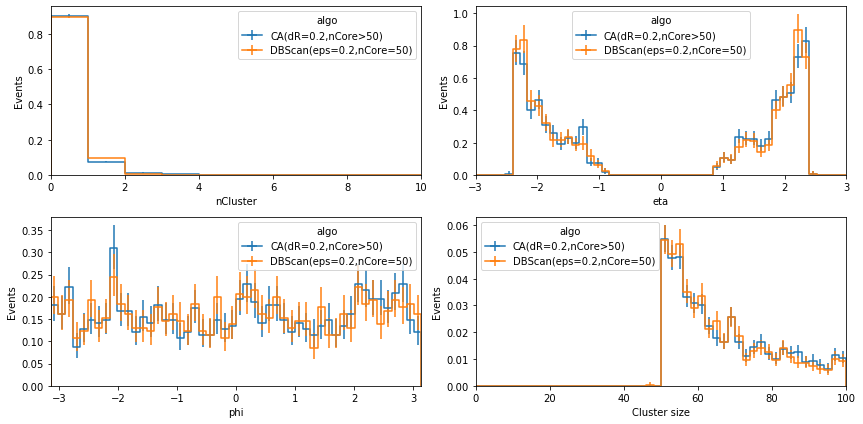

In [5]:
h=out['cluster']

ncols=2
nrows=2
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

hist.plot1d(out['nCluster'],ax=axs[0],density=True, overlay='algo',clear=False)
hist.plot1d(h.sum('phi','size'),ax=axs[1]   ,density=True, overlay='algo',clear=False)
hist.plot1d(h.sum('eta','size'),ax=axs[2]   ,density=True, overlay='algo',clear=False)
hist.plot1d(h.sum('eta','phi'),ax=axs[3]   ,density=True, overlay='algo',clear=False)

plt.tight_layout()
plt.show()